# Envs

In [2]:
"""
   Redo from DWF Python Example - Analog_Transistor.py
   Author:  Tran Le Phuong Lan
   Date:  2025-05-21

   Requires:                       
       Python 2.7, 3
"""

from ctypes import *

import math
import time
import sys
import os
from os import sep                # OS specific file path separators
import matplotlib.pyplot as plt
import numpy

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

if sys.platform.startswith("win"):
    dwf = cdll.dwf
    constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
elif sys.platform.startswith("darwin"): # on macOS
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
else: # on Linux
    dwf = cdll.LoadLibrary("libdwf.so")
    constants_path = sep + "usr" + sep + "share" + sep + "digilent" + sep + "waveforms" + sep + "samples" + sep + "py"

# Import constans
sys.path.append(constants_path)
import dwfconstants as constants

# Open the AD3

In [15]:
version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("Version: "+str(version.value))

cdevices = c_int()
dwf.FDwfEnum(0, byref(cdevices))
print("Number of Devices: "+str(cdevices.value))

if cdevices.value == 0:
    print("no device detected")
    quit()

dwf.FDwfParamSet(constants.DwfParamOnClose, 0) # 0 = run, 1 = stop, 2 = shutdown

print("Opening first device")
hdwf = c_int()
dwf.FDwfDeviceOpen(-1, byref(hdwf))

if hdwf.value == constants.hdwfNone.value:
    print("failed to open device")
    quit()

Version: b'3.24.2'
Number of Devices: 1
Opening first device


In [16]:
dwf.FDwfDeviceAutoConfigureSet(hdwf, 0) # 0 = the device will only be configured when FDwf###Configure is called

1

# code from analog_transistor.py but 

**the physical setup is**

- 1. W1 - OSC1

- 2. W2 - OSC2

In [17]:
print("Configuring device...")
# collector: 0V to 5V triangle output and 50Hz, 20ms
dwf.FDwfAnalogOutEnableSet(hdwf, 0, 1) 
dwf.FDwfAnalogOutFunctionSet(hdwf, 0, constants.funcTriangle)
dwf.FDwfAnalogOutPhaseSet(hdwf, 0, c_double(270.0))
dwf.FDwfAnalogOutFrequencySet(hdwf, 0, c_double(50))
dwf.FDwfAnalogOutOffsetSet(hdwf, 0, c_double(2.5))
dwf.FDwfAnalogOutAmplitudeSet(hdwf, 0, c_double(2.5))
dwf.FDwfAnalogOutMasterSet(hdwf, 0, 1)
dwf.FDwfAnalogOutConfigure(hdwf, 0, 0)

# base: 1V to 2V in 5 steps at 10Hz, 100ms total length
dwf.FDwfAnalogOutEnableSet(hdwf, 1, 1) 
dwf.FDwfAnalogOutFunctionSet(hdwf, 1, constants.funcCustom)
dwf.FDwfAnalogOutFrequencySet(hdwf, 1, c_double(10))
dwf.FDwfAnalogOutOffsetSet(hdwf, 1, c_double(1.5))
dwf.FDwfAnalogOutAmplitudeSet(hdwf, 1, c_double(0.5))
# values normalized to +-1 
# ChatGPT: using Python's ctypes module to create a C-style array of 5 double values.
rgSteps = (c_double*5)(-1.0, -0.5, 0, 0.5, 1.0) 
# The output value will be Offset + Sample*Amplitude
# The Sample = values in rgSteps
dwf.FDwfAnalogOutDataSet(hdwf, 1, rgSteps, len(rgSteps))
dwf.FDwfAnalogOutRunSet(hdwf, 1, c_double(0.1))
dwf.FDwfAnalogOutRepeatSet(hdwf, 1, 1)
dwf.FDwfAnalogOutConfigure(hdwf, 1, 0)

# scope: 5000 samples at 50kHz, 100ms
dwf.FDwfAnalogInChannelEnableSet(hdwf, 0, 1)
dwf.FDwfAnalogInChannelEnableSet(hdwf, 1, 1)
dwf.FDwfAnalogInFrequencySet(hdwf, c_double(50e3))
dwf.FDwfAnalogInChannelRangeSet(hdwf, 0, c_double(10.0))
dwf.FDwfAnalogInChannelRangeSet(hdwf, 1, c_double(10.0))
dwf.FDwfAnalogInBufferSizeSet(hdwf, 5000)
dwf.FDwfAnalogInTriggerSourceSet(hdwf, constants.trigsrcAnalogOut2) 
dwf.FDwfAnalogInTriggerPositionSet(hdwf, c_double(0.05)) # 5ms, trigger at first sample
dwf.FDwfAnalogInConfigure(hdwf, 1, 0)

print("Wait for the offset to stabilize...")
time.sleep(1)

print("Starting test...")
dwf.FDwfAnalogInConfigure(hdwf, 0, 1)
dwf.FDwfAnalogOutConfigure(hdwf, 1, 1)

sts = c_int()
while True:
    dwf.FDwfAnalogInStatus(hdwf, 1, byref(sts))
    if sts.value == constants.DwfStateDone.value :
        break
    time.sleep(0.001)
print("done")

rgc1 = (c_double*5000)()
rgc2 = (c_double*5000)()
dwf.FDwfAnalogInStatusData(hdwf, 0, rgc1, len(rgc1)) # get channel 1 data
dwf.FDwfAnalogInStatusData(hdwf, 1, rgc2, len(rgc2)) # get channel 2 data


Configuring device...
Wait for the offset to stabilize...
Starting test...
done


1

In [18]:
import numpy as np

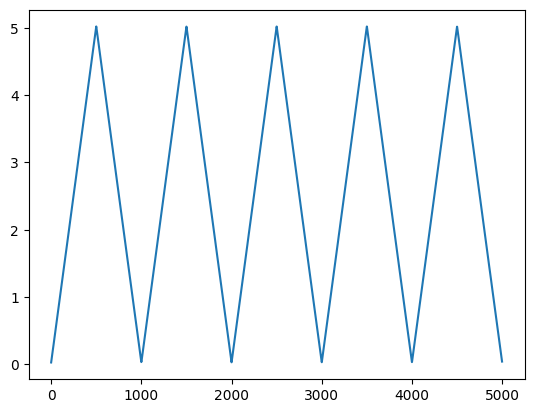

In [19]:
plt.plot(np.arange(0, len(rgc1)), rgc1)

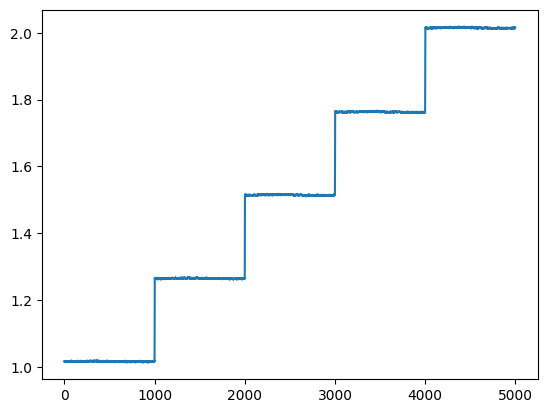

In [20]:
plt.plot(np.arange(0, len(rgc2)), rgc2)

# Wave Gen

## configure wave gen

In [ ]:
print("Configuring device...")

# collector: 0V to 5V triangle output and 50Hz, 20ms
# enable channel
# The following setup of FDwfAnalogOutNodeEnableSet is for normal use case of generating signal (i.e without modulation) 
#                         idxChannel AnalogOutNode   fMode
dwf.FDwfAnalogOutEnableSet(hdwf, 0, 1) 
# set function 
#                          idxChannel    AnalogOutNode func  
dwf.FDwfAnalogOutFunctionSet(hdwf, 0, constants.funcTriangle)
dwf.FDwfAnalogOutPhaseSet(hdwf, 0, c_double(270.0))
dwf.FDwfAnalogOutFrequencySet(hdwf, 0, c_double(50))
dwf.FDwfAnalogOutOffsetSet(hdwf, 0, c_double(2.5))
dwf.FDwfAnalogOutAmplitudeSet(hdwf, 0, c_double(2.5))
dwf.FDwfAnalogOutMasterSet(hdwf, 0, 1)
dwf.FDwfAnalogOutConfigure(hdwf, 0, 0)

# base: 1V to 2V in 5 steps at 10Hz, 100ms total length
dwf.FDwfAnalogOutEnableSet(hdwf, 1, 1) 
dwf.FDwfAnalogOutFunctionSet(hdwf, 1, constants.funcCustom)
dwf.FDwfAnalogOutFrequencySet(hdwf, 1, c_double(10))
dwf.FDwfAnalogOutOffsetSet(hdwf, 1, c_double(1.5))
dwf.FDwfAnalogOutAmplitudeSet(hdwf, 1, c_double(0.5))
# values normalized to +-1 
rgSteps = (c_double*5)(-1.0, -0.5, 0, 0.5, 1.0)
dwf.FDwfAnalogOutDataSet(hdwf, 1, rgSteps, len(rgSteps))
dwf.FDwfAnalogOutRunSet(hdwf, 1, c_double(0.1))
dwf.FDwfAnalogOutRepeatSet(hdwf, 1, 1)
dwf.FDwfAnalogOutConfigure(hdwf, 1, 0)

# Close AD3

In [14]:
dwf.FDwfDeviceCloseAll()

1